# Contour Monte Carlo: Embyonic stem-cell differentiation
This Julia notebook demonstrates how to perform Contour Monte Carlo to estimate cell population heterogeneity for the model described by eqs. (1)-(8) in "Single-cell data-driven mathematical model reveals possible molecular
mechanisms of embryonic stem-cell differentiation", Tu et al., 2019. Note that the code uses the `RCall` Julia package to call R, in order to use the vine copula kernel density estimation available in the R package `kdevine`.

In [1]:
using RCall, Compat, Random, Distributions, Plots, DifferentialEquations, LinearAlgebra, DelimitedFiles

R"library(kdevine)"
    
function f_solve(f_deriv, initial, tspan, parameters)
    prob = ODEProblem(f_deriv, initial, tspan, parameters)
    sol = solve(prob)
    return sol
end

function f_sample_solve_uniform(num_samples, population_sample, times_solve, tspan, f_solve, f_deriv, bounds, initial)
    n_params = size(bounds)[1]
    samples = zeros((num_samples, n_params))
    for i = 1:n_params
        samples[:, i] = rand(Uniform(bounds[i, 1], bounds[i, 2]), num_samples)
    end
    mOutputs = zeros((num_samples, length(population_sample)))
    for i in 1:num_samples
        sol = f_solve(f_deriv, initial, tspan, samples[i, :]);
        for j = 1:length(population_sample)
           mOutputs[i, j] = sol(times_solve[j], idxs=population_sample[j])
        end
    end
    return mOutputs
end

function f_sample_solve_uniform_uncertain_inits(num_samples, population_sample, times_solve,
        tspan, f_solve, f_deriv, bounds, nparams, ninits)
    n_params = size(bounds)[1]
    samples = zeros((num_samples, n_params))
    for i = 1:n_params
        samples[:, i] = rand(Uniform(bounds[i, 1], bounds[i, 2]), num_samples)
    end
    mOutputs = zeros((num_samples, length(population_sample)))
    for i in 1:num_samples
        sol = f_solve(f_deriv, samples[i, (nparams + 1):(nparams + ninits)], tspan, samples[i, 1:nparams]);
        for j = 1:length(population_sample)
           mOutputs[i, j] = sol(times_solve[j], idxs=population_sample[j])
        end
    end
    return mOutputs
end

function f_estimate_kdevine(mOutputs)
    @rput mOutputs
    R"fit <- kdevine(mOutputs)"
    R"saveRDS(fit, '../data/vine_fit.RDS')"
end

function dkdevine(params)
    @rput params
    R"z <- dkdevine(params, fit)"
    @rget z
    return z
end

function load_dkdevine_fit()
    R"z <- readRDS('../data/vine_fit.RDS')"
    @rget z
    return z
end

function f_step_bounds(vCurrent, bounds, sigma)
    vProposed = zeros(size(bounds)[1])
    for i = 1:length(vProposed)
        temp = (rand(Normal(vCurrent[i] - bounds[i, 1], sigma[i]), 1)[1] % (bounds[i, 2] - bounds[i, 1]))
        if temp < 0
            temp += bounds[i, 2]
        else
            temp += bounds[i, 1]
        end
        vProposed[i] = temp
    end
    return vProposed
end

function f_step_bounds_simple(vCurrent, bounds, sigma)
    vProposed = zeros(size(bounds)[1])
    for i = 1:length(vProposed)
        temp = rand(Normal(vCurrent[i], sigma[i]), 1)[1]
        vProposed[i] = temp
    end
    return vProposed
end

function f_mcmc_uniform_uncertain_ints(num_samples, target_fn, f_dkdevine, sigma,
        population_sample, times_solve, tspan, f_solve, f_deriv, bounds, initial_inputs, nparams, ninits)
    mInputs = zeros((num_samples, size(bounds)[1]))
    mOutputs = zeros((num_samples, length(population_sample)))
    vOutputs_temp = zeros(length(population_sample))
    vLogPDF = zeros(num_samples)
    vContour = zeros(num_samples)
    # initial points
    mInputs[1, :] = initial_inputs
    for j = 1:length(population_sample)
        sol = f_solve(f_deriv, mInputs[1, (nparams + 1):(nparams + ninits)], tspan, mInputs[1, 1:nparams]);
        mOutputs[1, j] = sol(times_solve[j], idxs=population_sample[j])
    end
    log_pdf_current = target_fn(mOutputs[1, :])
    log_contour_current = log(f_dkdevine(mOutputs[1, :]))
    # MCMC
    log_a = 0.0
    sigma = Matrix(Diagonal(sigma.^2))
    mu = initial_inputs
    for i = 2:num_samples
        if i <= (100 * (nparams + ninits))
            vProposed = rand(MvNormal(mInputs[i - 1, :], sigma), 1)
            if (sum(vProposed .< bounds[:, 1]) > 0) || (sum(vProposed .> bounds[:, 2]) > 0)
                mInputs[i, :] = mInputs[i - 1, :]
                mOutputs[i, :] = mOutputs[i - 1, :]
                accepted = 0.0
            else
                sol = f_solve(f_deriv, vProposed[(nparams + 1):(nparams + ninits)], tspan, vProposed[1:nparams]);
                for j = 1:length(population_sample)
                    vOutputs_temp[j] = sol(times_solve[j], idxs=population_sample[j]);
                end
                log_pdf_proposed = target_fn(vOutputs_temp)
                log_contour_proposed = log(f_dkdevine(vOutputs_temp))
                log_r = ((log_pdf_proposed + log_contour_current) -
                         (log_pdf_current + log_contour_proposed))
                if (log_r > log(rand(Uniform(), 1)[1])) && (log_contour_proposed > -4)
                    mInputs[i, :] = vProposed
                    mOutputs[i, :] = vOutputs_temp
                    log_pdf_current = log_pdf_proposed
                    log_contour_current = log_contour_proposed
                    accepted = 1.0
                else
                    mInputs[i, :] = mInputs[i - 1, :]
                    mOutputs[i, :] = mOutputs[i - 1, :]
                    accepted = 0.0
                end
            end
            vLogPDF[i] = log_pdf_current
            vContour[i] = log_contour_current
        else
            s = i - (100 * (nparams + ninits))
            gamma = (s + 1)^(-0.6)
            vProposed = rand(MvNormal(mInputs[i - 1, :], Matrix(Hermitian(sigma)) * exp(log_a)), 1)
            if (sum(vProposed .< bounds[:, 1]) > 0) || (sum(vProposed .> bounds[:, 2]) > 0)
                mInputs[i, :] = mInputs[i - 1, :]
                mOutputs[i, :] = mOutputs[i - 1, :]
                accepted = 0.0
            else
                sol = f_solve(f_deriv, vProposed[(nparams + 1):(nparams + ninits)], tspan, vProposed[1:nparams]);
                for j = 1:length(population_sample)
                    vOutputs_temp[j] = sol(times_solve[j], idxs=population_sample[j]);
                end
                log_pdf_proposed = target_fn(vOutputs_temp)
                log_contour_proposed = log(f_dkdevine(vOutputs_temp))
                log_r = ((log_pdf_proposed + log_contour_current) -
                         (log_pdf_current + log_contour_proposed))
                if (log_r > log(rand(Uniform(), 1)[1])) && (log_contour_proposed > -4)
                    mInputs[i, :] = vProposed
                    mOutputs[i, :] = vOutputs_temp
                    log_pdf_current = log_pdf_proposed
                    log_contour_current = log_contour_proposed
                    accepted = 1.0
                else
                    mInputs[i, :] = mInputs[i - 1, :]
                    mOutputs[i, :] = mOutputs[i - 1, :]
                    accepted = 0.0
                end
            end
            vLogPDF[i] = log_pdf_current
            vContour[i] = log_contour_current
            sigma = (1 - gamma) * sigma + gamma * (mInputs[i, :] - mu) * (mInputs[i, :] - mu)'
            mu = (1 - gamma) * mu + gamma * mInputs[i, :]
            log_a += gamma * (accepted - 0.25)
        end
    end
    return Dict("inputs" => mInputs, "outputs" => mOutputs, "log_pdf" => vLogPDF, "contour_volume" => vContour)
end

function f_mcmc_uniform(num_samples, target_fn, f_dkdevine, sigma,
        population_sample, times_solve, tspan, f_solve, f_deriv, bounds, initial_inputs, initial)
    mInputs = zeros((num_samples, size(bounds)[1]))
    mOutputs = zeros((num_samples, length(population_sample)))
    vOutputs_temp = zeros(length(population_sample))
    vLogPDF = zeros(num_samples)
    vContour = zeros(num_samples)
    # initial points
    mInputs[1, :] = initial_inputs
    for j = 1:length(population_sample)
        sol = f_solve(f_deriv, initial, tspan, mInputs[1, :]);
        mOutputs[1, j] = sol(times_solve[j], idxs=population_sample[j])
    end
    log_pdf_current = target_fn(mOutputs[1, :])
    log_contour_current = log(f_dkdevine(mOutputs[1, :]))
    # MCMC
    log_a = 0.0
    sigma = Matrix(Diagonal(sigma.^2))
    mu = initial_inputs
    for i = 2:num_samples
        if i <= (100 * length(initial_inputs))
            vProposed = rand(MvNormal(mInputs[i - 1, :], sigma), 1)
            if (sum(vProposed .< bounds[:, 1]) > 0) || (sum(vProposed .> bounds[:, 2]) > 0)
                mInputs[i, :] = mInputs[i - 1, :]
                mOutputs[i, :] = mOutputs[i - 1, :]
                accepted = 0.0
            else
                sol = f_solve(f_deriv, initial, tspan, vProposed);
                for j = 1:length(population_sample)
                    vOutputs_temp[j] = sol(times_solve[j], idxs=population_sample[j]);
                end
                log_pdf_proposed = target_fn(vOutputs_temp)
                log_contour_proposed = log(f_dkdevine(vOutputs_temp))
                log_r = ((log_pdf_proposed + log_contour_current) -
                         (log_pdf_current + log_contour_proposed))
                if (log_r > log(rand(Uniform(), 1)[1])) && (log_contour_proposed > -4)
                    mInputs[i, :] = vProposed
                    mOutputs[i, :] = vOutputs_temp
                    log_pdf_current = log_pdf_proposed
                    log_contour_current = log_contour_proposed
                    accepted = 1.0
                else
                    mInputs[i, :] = mInputs[i - 1, :]
                    mOutputs[i, :] = mOutputs[i - 1, :]
                    accepted = 0.0
                end
            end
            vLogPDF[i] = log_pdf_current
            vContour[i] = log_contour_current
        else
            s = i - (100 * length(initial_inputs))
            gamma = (s + 1)^(-0.6)
            vProposed = rand(MvNormal(mInputs[i - 1, :], Matrix(Hermitian(sigma)) * exp(log_a)), 1)
            if (sum(vProposed .< bounds[:, 1]) > 0) || (sum(vProposed .> bounds[:, 2]) > 0)
                mInputs[i, :] = mInputs[i - 1, :]
                mOutputs[i, :] = mOutputs[i - 1, :]
                accepted = 0.0
            else
                sol = f_solve(f_deriv, initial, tspan, vProposed);
                for j = 1:length(population_sample)
                    vOutputs_temp[j] = sol(times_solve[j], idxs=population_sample[j]);
                end
                log_pdf_proposed = target_fn(vOutputs_temp)
                log_contour_proposed = log(f_dkdevine(vOutputs_temp))
                log_r = ((log_pdf_proposed + log_contour_current) -
                         (log_pdf_current + log_contour_proposed))
                if (log_r > log(rand(Uniform(), 1)[1])) && (log_contour_proposed > -4)
                    mInputs[i, :] = vProposed
                    mOutputs[i, :] = vOutputs_temp
                    log_pdf_current = log_pdf_proposed
                    log_contour_current = log_contour_proposed
                    accepted = 1.0
                else
                    mInputs[i, :] = mInputs[i - 1, :]
                    mOutputs[i, :] = mOutputs[i - 1, :]
                    accepted = 0.0
                end
            end
            vLogPDF[i] = log_pdf_current
            vContour[i] = log_contour_current
            sigma = (1 - gamma) * sigma + gamma * (mInputs[i, :] - mu) * (mInputs[i, :] - mu)'
            mu = (1 - gamma) * mu + gamma * mInputs[i, :]
            log_a += gamma * (accepted - 0.25)
        end
    end
    return Dict("inputs" => mInputs, "outputs" => mOutputs, "log_pdf" => vLogPDF, "contour_volume" => vContour)
end

function f_log_pdf(v_values, v_dist)
    log_pdf = 0.0
    k = 1
    for val in v_values
        log_pdf += logpdf(v_dist[k], val)
        k += 1
    end
    return log_pdf
    end

function f_mcmc_uniform_multiple(nchains, num_samples, target_fn, f_dkdevine, sigma,
        population_sample, times_solve, tspan, f_solve, f_deriv, bounds, initial_inputs, initial)
    vResults = []
    for i = 1:nchains
         push!(vResults, f_mcmc_uniform(num_samples, target_fn, f_dkdevine, sigma,
        population_sample, times_solve, tspan, f_solve, f_deriv, bounds, initial_inputs, initial))
    end
    return vResults
end

function f_mcmc_uniform_uncertain_ints_multiple(nchains, num_samples, target_fn, f_dkdevine, sigma,
        population_sample, times_solve, tspan, f_solve, f_deriv, bounds, initial_inputs, nparams, ninits)
    vResults = []
    for i = 1:nchains
         push!(vResults, f_mcmc_uniform_uncertain_ints(num_samples, target_fn, f_dkdevine, sigma,
        population_sample, times_solve, tspan, f_solve, f_deriv, bounds, initial_inputs, nparams, ninits))
    end
    return vResults
end

function f_between(vResults)
    nchains = length(vResults)
    inputs = vResults[1]["inputs"];
    nparams = size(inputs)[2];
    mMeans = zeros((nchains, nparams));
    for i = 1:nchains
        inputs = vResults[i]["inputs"];
        for j = 1:nparams
            mMeans[i, j] = mean(inputs[:, j]);
        end
    end
    t = size(inputs)[1];
    vOverallMean = mean(mMeans, dims=1);
    vVar = (t / (nchains - 1)) * sum((mMeans .- vOverallMean).^2, dims=1);
    return vVar
end

function f_within(vResults)
    nchains = length(vResults)
    inputs = vResults[1]["inputs"];
    nparams = size(inputs)[2];
    mVars = zeros((nchains, nparams));
    for i = 1:nchains
        inputs = vResults[i]["inputs"];
        for j = 1:nparams
            mVars[i, j] = var(inputs[:, j]);
        end
    end
    return mean(mVars, dims=1)
end

function f_rhat(vResults)
    nchains = length(vResults)
    inputs = vResults[1]["inputs"];
    nparams = size(inputs)[2];
    t = size(inputs)[1];
    vWithin = f_within(vResults);
    vBetween = f_between(vResults);
    return sqrt.((vBetween ./ t + vWithin) ./ vWithin)
end

┌ Info: Recompiling stale cache file /Users/appleuser/.julia/compiled/v1.0/RCall/8GFyb.ji for RCall [6f49c342-dc21-5d91-9882-a32aef131414]
└ @ Base loading.jl:1187
┌ Info: Recompiling stale cache file /Users/appleuser/.julia/compiled/v1.0/Plots/ld3vC.ji for Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1187
┌ Info: Recompiling stale cache file /Users/appleuser/.julia/compiled/v1.0/DifferentialEquations/UQdwS.ji for DifferentialEquations [0c46a032-eb83-5123-abaf-570d42b7fbaa]
└ @ Base loading.jl:1187
┌ Warning: RCall.jl: The kdevine package is no longer actively developed. Consider using 
│    - the 'kde1d' package for marginal estimation, 
│    - the functions vine() and vinecop() from the 'rvinecopulib' 
│      package as replacements for kdevine() and kdevincop().
└ @ RCall /Users/appleuser/.julia/packages/RCall/Qzssx/src/io.jl:160


f_rhat (generic function with 1 method)

### Plot solution at parameter values given in Table S1

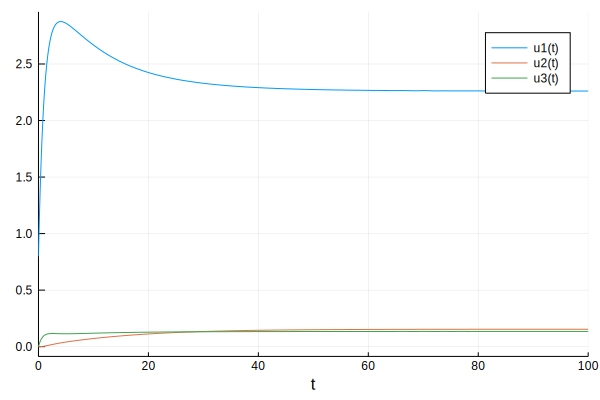

In [2]:
function deriv_tu_2019(dydt, y, p, t)
    dydt[1] = 1 / (1 + p[1] * y[2]^2) + p[2] / (1 + y[3]^2) - y[1]
    dydt[2] = y[3]^2 / (1 + p[3] * y[3]^2) - p[4] * y[2]
    dydt[3] = p[5] / (p[6] + y[1]^2) - p[7] * y[3]
end

sol = f_solve(deriv_tu_2019, [0.8; 0; 0], (0.0, 100.0), [100; 2; 9.5; 0.1; 2.3; 12.0; 1.0]);
plot(sol)

### First estimate volume of contours.

In [117]:
# number of independent samples to take from bounds
ncontourvolsteps = 100000

# bounds of parameters (uniform prior within bounds assumed)
mBounds = [[40 60]; [2 10]; [0.5 16]; [0 0.7]; [2 4]; [2 20]; [0 0.2]];

tspan = (0.0, 73.0)
initial_states = [1.5; 0.0; 0.0];
populations_observed = [1, 3, 1, 3]
times_observed = [12, 12, 72, 72]

mOutputs = @time f_sample_solve_uniform(ncontourvolsteps, populations_observed, times_observed,
    tspan, f_solve, deriv_tu_2019, mBounds, initial_states);

@time f_estimate_kdevine(mOutputs);

 35.614060 seconds (100.88 M allocations: 8.245 GiB, 11.40% gc time)
1389.781427 seconds (114 allocations: 3.484 KiB)


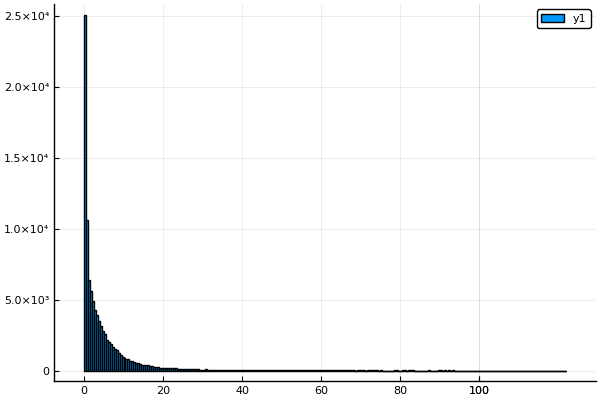

In [124]:
histogram(mOutputs[:, 4])

Perform MCMC.

In [126]:
dist = MvNormal([5.5, 0.45, 2.0, 3.8],
       [[1.1  0.1  0.0 0.0];
        [0.1  0.30 0.0 0.0];
        [0.0  0.0  1.9 0.7]; 
        [0.0  0.0  0.7 1.9]])

# number of chains (not run in parallel due to RCall)
nchains = 4
# number of MCMC steps (adapting after 100 * length(initial_parametesr))
nsamples = 10000
# MCMC initial (before adaptation) step sizes
sigma = [0.5, 0.05, 0.2, 0.01, 0.02, 0.05, 0.02]
# initial parameters
initial_parameters = [50; 5; 1; 0.1; 3.5; 14; 0.1]

vResults = @time f_mcmc_uniform_multiple(nchains, nsamples, x -> logpdf(dist, x), dkdevine,
                    sigma, populations_observed, times_observed, tspan,
                    f_solve, deriv_tu_2019,
                    mBounds, initial_parameters, initial_states);

1637.129758 seconds (22.74 M allocations: 2.118 GiB, 0.06% gc time)


Check convergence diagnostics.

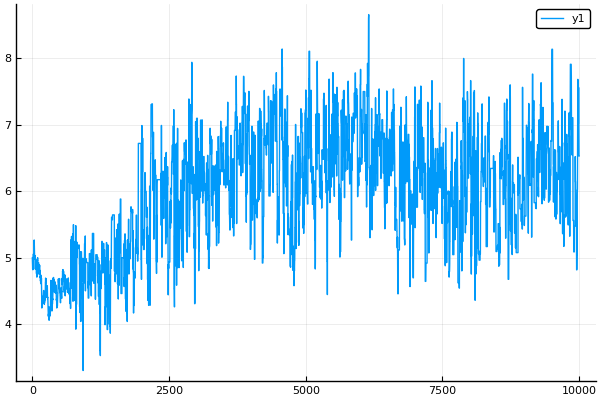

In [127]:
plot(vResults[3]["inputs"][1:end, 2])

In [128]:
f_rhat(vResults)

1×7 Array{Float64,2}:
 1.01139  1.01137  1.00617  1.02607  1.04943  1.02497  1.01846

In [129]:
mean(vResults[1]["outputs"], dims=1)

1×4 Array{Float64,2}:
 5.34359  0.505055  0.894904  2.99668

In [130]:
cov(vResults[1]["outputs"])

4×4 Array{Float64,2}:
  0.739015    -0.0648813    0.00644113   0.102075 
 -0.0648813    0.00985891  -0.0166071    0.0284301
  0.00644113  -0.0166071    0.234897    -0.390204 
  0.102075     0.0284301   -0.390204     0.90886  

Plot output samples at t = 12 hours.

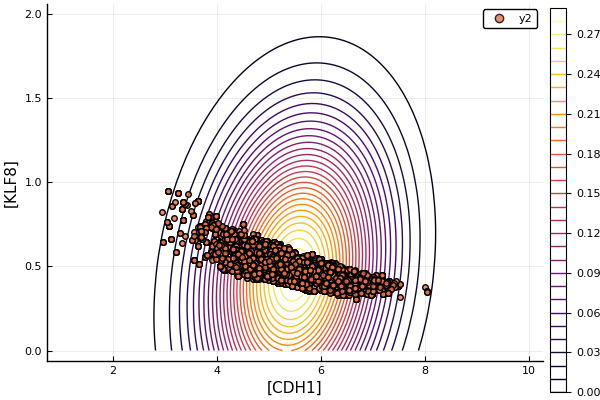

In [134]:
nwarmup = 2000
noutputs = nsamples

dist1 = MvNormal([5.5, 0.45],
        [[1.1  0.1];
        [0.1  0.30]])

pyplot()
V(x,y) = pdf(dist1, [x, y])
x = range(1, 10, length=100)
y = range(0, 2, length=100)
contour(x, y, (x,y)->V(x,y), levels=30)
scatter!(vResults[1]["outputs"][nwarmup:noutputs, 1], vResults[1]["outputs"][nwarmup:noutputs, 2], alpha=0.8)
xlabel!("[CDH1]")
ylabel!("[KLF8]")

At t = 72 hours.

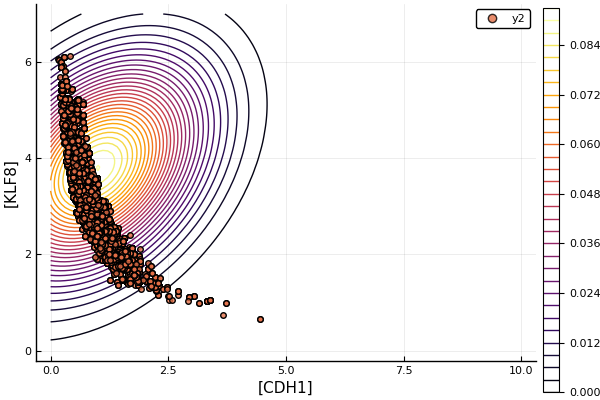

In [133]:
nwarmup = 2000
noutputs = nsamples

dist1 = MvNormal([1.0, 3.8],
        [[1.9  0.7];
         [0.7  1.9]])

pyplot()
V(x,y) = pdf(dist1, [x, y])
x = range(0, 10, length=100)
y = range(0, 7, length=100)
contour(x, y, (x,y)->V(x,y), levels=30)
scatter!(vResults[1]["outputs"][nwarmup:noutputs, 3], vResults[1]["outputs"][nwarmup:noutputs, 4], alpha=0.8)
xlabel!("[CDH1]")
ylabel!("[KLF8]")

Plot parameter samples.

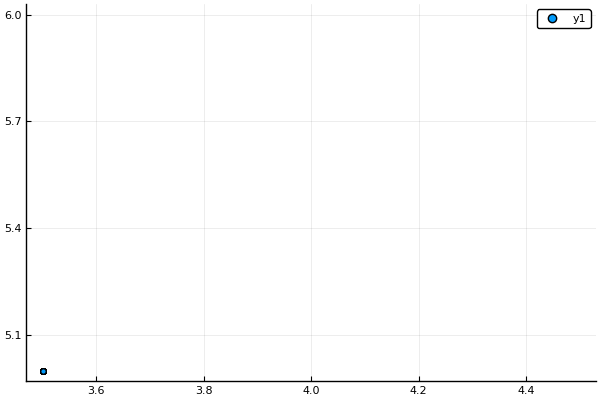

In [112]:
scatter(vResults[1]["inputs"][1:end, 5], vResults[1]["inputs"][1:end, 2])

### Two-dimensional output distribution

Estimate contour volumes.

In [419]:
function f_estimate_kdevine(mOutputs)
    @rput mOutputs
    R"fit <- kdevine(mOutputs, mult_1d = 0.5)"
    R"saveRDS(fit, '../data/vine_fit.RDS')"
end

# number of independent samples to take from bounds
ncontourvolsteps = 10000

# bounds of parameters (uniform prior within bounds assumed)
mBounds = [[0 100]; [2 10]; [0.5 10]; [0 2]; [2 4]; [0 20]; [0 0.2]];

tspan = (0.0, 73.0)
initial_states = [1.5; 0.0; 0.0];
populations_observed = [1, 1]
times_observed = [12, 36]

mOutputs = @time f_sample_solve_uniform(ncontourvolsteps, populations_observed, times_observed,
    tspan, f_solve, deriv_tu_2019, mBounds, initial_states);

@time f_estimate_kdevine(mOutputs);

  3.656789 seconds (10.08 M allocations: 872.274 MiB, 12.23% gc time)


RCall.REvalError: REvalError: Error in kdevine(mOutputs) : x must be multivariate or a factor.

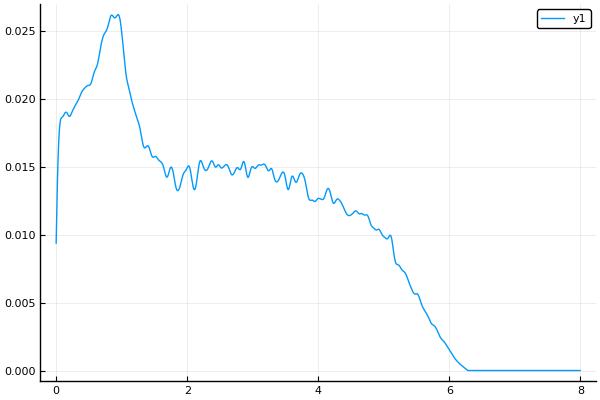

In [410]:
x = 0:0.01:8
y = map(a -> dkdevine([5, a]), x);
plot(x, y)

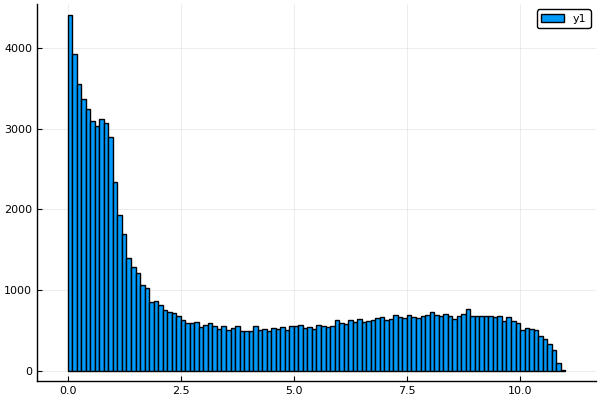

In [411]:
histogram(mOutputs[:, 2],bins=100)

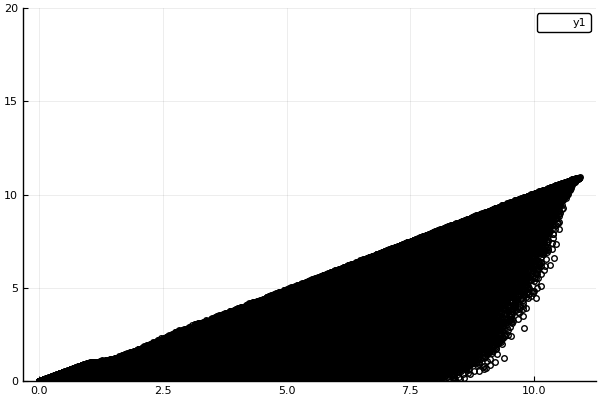

In [412]:
scatter(mOutputs[:, 1], mOutputs[:, 2], alpha=0.001, ylims=(0, 20))

Perform MCMC.

In [413]:
function f_combined_dist(v_values)
    dist_1 = Normal(5.5, 1.1)
    dist_2 = Gamma(3.1, 1 / 0.95)
    return logpdf(dist_1, v_values[1]) + logpdf(dist_2, v_values[2])
end

# number of chains (not run in parallel due to RCall)
nchains = 4
# number of MCMC steps (adapting after 100 * length(initial_parametesr))
nsamples = 10000
# MCMC initial (before adaptation) step sizes
sigma = [0.5, 0.05, 0.2, 0.01, 0.02, 0.05, 0.02]
# initial parameters
initial_parameters = [50; 5; 1; 0.1; 3.5; 14; 0.1]

vResults = @time f_mcmc_uniform_multiple(nchains, nsamples, x -> f_combined_dist(x), dkdevine,
                    sigma, populations_observed, times_observed, tspan,
                    f_solve, deriv_tu_2019,
                    mBounds, initial_parameters, initial_states);

831.967242 seconds (22.81 M allocations: 2.174 GiB, 0.14% gc time)


In [414]:
f_rhat(vResults)

1×7 Array{Float64,2}:
 1.03453  1.00919  1.01426  1.01575  1.03485  1.03162  1.01175

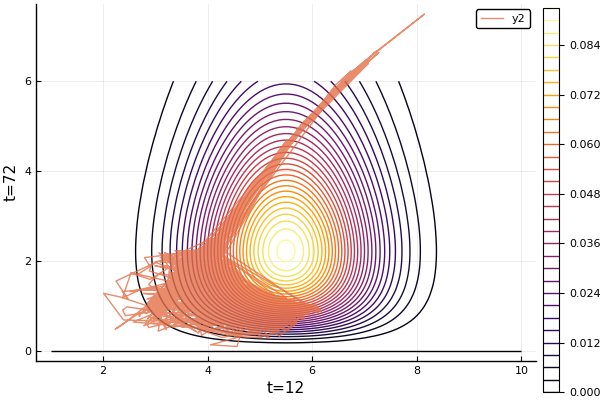

In [415]:
nwarmup = 1
noutputs = nsamples

dist = MvNormal([5.5, 2],
       [[1.1  0.0]; 
        [0.0 1.9]])

pyplot()
V(x,y) = exp(f_combined_dist([x, y]))
x = range(1, 10, length=100)
y = range(0, 6, length=100)
contour(x, y, (x,y)->V(x,y), levels=30)
plot!(vResults[2]["outputs"][nwarmup:noutputs, 1], vResults[2]["outputs"][nwarmup:noutputs, 2], alpha=0.8)
xlabel!("t=12")
ylabel!("t=72")

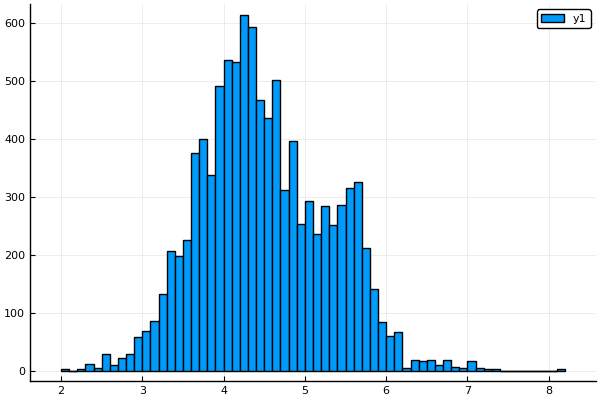

In [416]:
histogram(vResults[2]["outputs"][nwarmup:noutputs, 1])

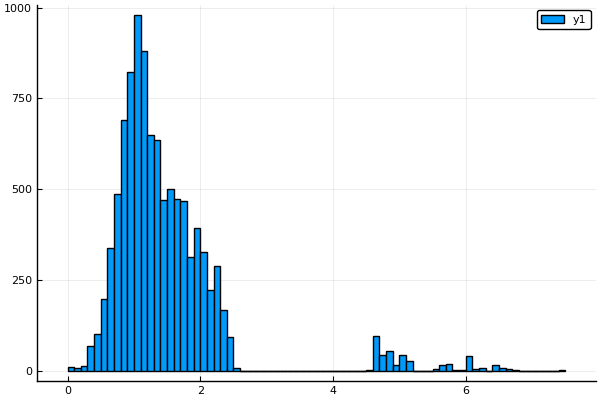

In [417]:
histogram(vResults[2]["outputs"][nwarmup:noutputs, 2])